# Data
-------------

What is data?

What is metadata?

# An example data set
Let's work through some common operations involved with *reading* in and *displaying* data. These files were downloaded from [Kauring data](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/70811):


Inside the KauringGravity folder are a few files:
 * A point located [data file](KauringGravity/Kauring%20AG-AGG%20Ground%20Gravity%202009%20AGG%20Area%20Data.dat)
 * a [README](KauringGravity/Kauring%20AG-AGG%20Ground%20Gravity%202009%20AGG%20Area%20Data%20--%20README.txt)
 * A [header file](Lectures/Fundamentals/KauringGravity/Kauring%20AG-AGG%20Ground%20Gravity%202009%20AGG%20Area%20Data.dfn) describing the columns of the data files

You are all likely familiar with using pandas to read in data files, so let's stick with that.

In [1]:
import pandas as pd

In [2]:
data_file_name = 'KauringGravity/Kauring AG-AGG Ground Gravity 2009 AGG Area Data.dat'

In [3]:
pd.read_table(data_file_name)

,"200960 6493882 20096006965 ""null"" D 117.019181 -31.890046 DEG GDA94 GPS 0.050 m 1 257.881 m AHD GPS TR 0.095 m 1 231.247 m GRS80 ELN 0.155 m 3 9794026.8400 um B 0.18 um 1 CG5 null 257.881 m GPS 0.095 m 1 231.247 m ELN 0.155 m 3 -26.634 m AUSGEOID98 GRS80 W98 0.060 m 3 0.63 um RTC 2.67 9999.00 null 9999 2009-02-07 9999-12-31 6 ""GPS, Gravity base:20096000146 Meter CG5071040291"" -5.17 -267.29 77.08 -211.49 1 501813.91 6471751.61"
0,"200960 6489221 20096006966 ""..."
1,"200960 6493883 20096006967 ""..."
2,"200960 6493884 20096006968 ""..."
3,"200960 6489937 20096006969 ""..."
4,"200960 6493885 20096006970 ""..."
...,...
3637,"200960 6487380 20096010604 ""..."
3638,"200960 6488467 20096010605 ""..."
3639,"200960 6486653 20096010606 ""..."
3640,"200960 6498162 20096010607 ""..."


That did something, there is data there, but likely not in a way we can actually use it...

Let's give panda's some more information, starting with explicitly telling it the delimiter (separator)

In [ ]:
pd.read_table(data_file_name) 

Well that looks better, we have the expected number of columns!

What else is wrong though?

In [ ]:
# don't interpret the first line as a header, it is actually data
pd.read_table(data_file_name, sep=r"\s+", header=None)

Now what?

This data is in a completely useable format, but it could be a bit easier if we gave each column an appropriate name...

The `.dfn` file has some good names! Let's make a list of them.

In [6]:
header_file_name = 'KauringGravity/Kauring AG-AGG Ground Gravity 2009 AGG Area Data.dfn'

In [7]:
with open(header_file_name) as f:
    while line:=f.readline():
        print(line)

DEFN   ST=RECD,RT=COMM;RT:A4;COMMENTS:A76

DEFN 1 ST=RECD,RT=;SURVEY_NUMBER:I15:NULL=9999

DEFN 2 ST=RECD,RT=;OBSERVATION_NUMBER:I13:NULL=9999

DEFN 3 ST=RECD,RT=;STATION_NUMBER:I16:NULL=9999

DEFN 4 ST=RECD,RT=;STATION_NAME:A33:NULL=9999

DEFN 5 ST=RECD,RT=;STATION_TYPE:A6:NULL=9999

DEFN 6 ST=RECD,RT=;LONGITUDE:F17.6:NULL=9999

DEFN 7 ST=RECD,RT=;LATITUDE:F17.6:NULL=9999

DEFN 8 ST=RECD,RT=;LOCATION_UNITS:A6:NULL=9999

DEFN 9 ST=RECD,RT=;GEODETIC_DATUM:A13:NULL=9999

DEFN 10 ST=RECD,RT=;METHOD_OF_LOCATION:A5:NULL=9999

DEFN 11 ST=RECD,RT=;ACCURACY_OF_LOCATION:F9.3:NULL=9999

DEFN 12 ST=RECD,RT=;UNITS_OF_LOCATION_ACCURACY:A9:NULL=9999

DEFN 13 ST=RECD,RT=;METHOD_OF_LOCATION_ACCURACY:I5:NULL=9999

DEFN 14 ST=RECD,RT=;GEOID_GROUND_ELEVATION:F9.3:NULL=9999

DEFN 15 ST=RECD,RT=;UNITS_OF_GEOID_GND_ELEV:A5:NULL=9999

DEFN 16 ST=RECD,RT=;GEOID_GND_ELEV_DATUM:A6:NULL=9999

DEFN 17 ST=RECD,RT=;METHOD_OF_GEOID_GND_ELEV:A5:NULL=9999

DEFN 18 ST=RECD,RT=;GEOID_GND_ELEV_TYPE:A5:NULL=9999

DEFN 19 

Looks like there are descriptions of two data files in here:
1) The point data
2) The coordinate reference frame

Let's grab the labels of the data frame here

an example line looks like 

`DEFN 23 ST=RECD,RT=;UNITS_OF_ELLIPSOID_GROUND_HGT:A7:NULL=9999`

how can we separate out the `UNITS_OF_ELLIPSOID_GROUND_HGT` from the above string?

In [ ]:
example_line = "DEFN 23 ST=RECD,RT=;UNITS_OF_ELLIPSOID_GROUND_HGT:A7:NULL=9999\n"

In [ ]:
labels = []
with open(header_file_name) as f:
    f.readline() # read the first line, and do nothing
    for i in range(74): # read the next 74 lines
        line = f.readline()
        name = line.split(";")[1].split(":")[0]
        labels.append(name)
labels

In [25]:
# Now let's also give the pandas reader the column names
dat = pd.read_table(data_file_name, sep=r"\s+", names=labels)
dat

,SURVEY_NUMBER,OBSERVATION_NUMBER,STATION_NUMBER,STATION_NAME,STATION_TYPE,LONGITUDE,LATITUDE,LOCATION_UNITS,GEODETIC_DATUM,METHOD_OF_LOCATION,...,PROCESSING_DATE,ESTIMATE_OF_STN_RELIABILITY,COMMENTS,ELLIPSOID_FREEAIR_ANOMALY,SPHERICAL_CAP_BOUGUER_ANOMALY,GEOIDAL_FREEAIR_ANOMALY,INFINITE_SLAB_BOUGUER_ANOMALY,GRIDDING_FLAG,X_GDA94_MGA50,Y_GDA94_MGA50
0,200960,6493882,20096006965,NaN,D,117.019181,-31.890046,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5071040291",-5.17,-267.29,77.08,-211.49,1,501813.91,6471751.61
1,200960,6489221,20096006966,NaN,D,117.020090,-31.889598,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5071040291",-12.01,-269.97,70.23,-214.23,1,501899.88,6471801.25
2,200960,6493883,20096006967,NaN,D,117.020997,-31.889159,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5071040291",-19.13,-272.94,63.11,-217.25,1,501985.66,6471849.90
3,200960,6493884,20096006968,NaN,D,117.021876,-31.888713,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5071040291",-23.12,-273.42,59.11,-217.77,1,502068.80,6471899.31
4,200960,6489937,20096006969,NaN,D,117.022814,-31.888277,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5071040291",-21.74,-272.87,60.49,-217.22,1,502157.51,6471947.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,200960,6487380,20096010604,NaN,D,117.090415,-31.912222,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5080440372",16.97,-324.23,99.06,-267.57,1,508548.31,6469290.20
3639,200960,6488467,20096010605,NaN,D,117.091326,-31.911773,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5080440372",15.65,-324.23,97.74,-267.59,1,508634.48,6469339.90
3640,200960,6486653,20096010606,NaN,D,117.092226,-31.911294,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5080440372",12.74,-323.56,94.84,-266.96,1,508719.62,6469392.92
3641,200960,6498162,20096010607,NaN,D,117.093096,-31.910884,DEG,GDA94,GPS,...,9999-12-31,6,"GPS, Gravity base:20096000146 Meter CG5080440372",8.27,-323.07,90.36,-266.54,1,508801.91,6469438.29


## Key thoughts on reading in data files
* Data on its own is useless without metadata
* Make use of available data readers (`pandas` or `numpy` in python)
    * do not write code to read in data unless you absolutely have to
    * You'll likely need to pass specific parameters to these functions to make it work with your file.

# Fundamental thoughts on displaying data
You want to be able to interpret the data you collect, often visually.

in python `matplotlib` is often a great place to start.

In [16]:
import matplotlib.pyplot as plt

In [18]:
lats = dat['LATITUDE']
lons = dat['LONGITUDE']

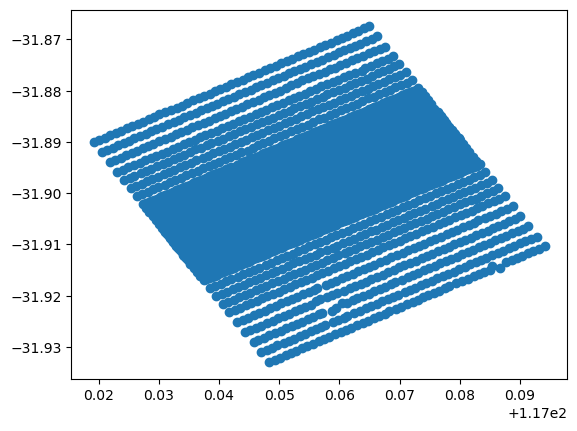

In [20]:
# creating a simple scatter plot
plt.scatter(lons, lats)

It looks like this data set also has UTM coordinates associated with it too!

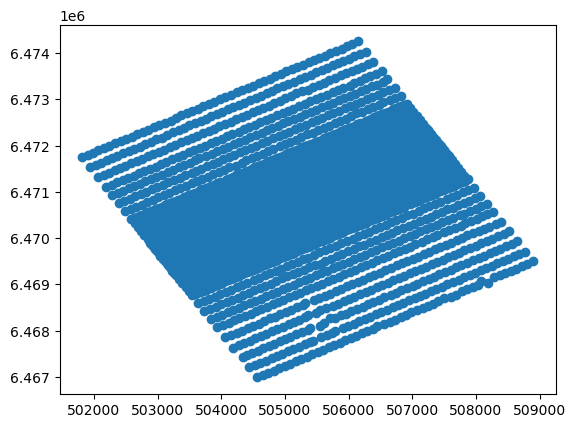

In [51]:
dat_x = dat['X_GDA94_MGA50']
dat_y = dat['Y_GDA94_MGA50']
plt.scatter(dat_x, dat_y)

What's missing from these plots?

How can we make them better?

## Plotting values associated with spatial locations

Q: What's difficult about plotting values associated with these locations?

* It's not a regular grid
* It's at an angle

Some options:
1) Color the scatter plot points

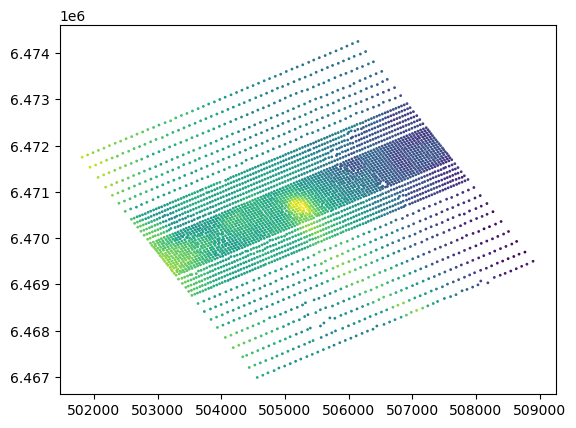

In [54]:
grav_v = dat['INFINITE_SLAB_BOUGUER_ANOMALY']
plt.scatter(dat_x, dat_y, c=grav_v, s=1)

2) Interpolate to a regular grid and plot

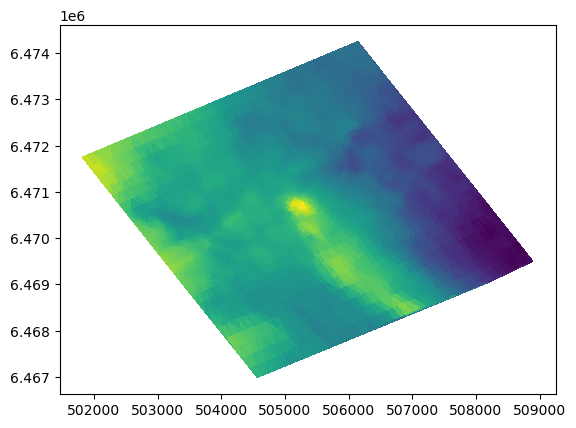

In [42]:
# The easy way!
plt.tripcolor(dat_x, dat_y, grav_v)

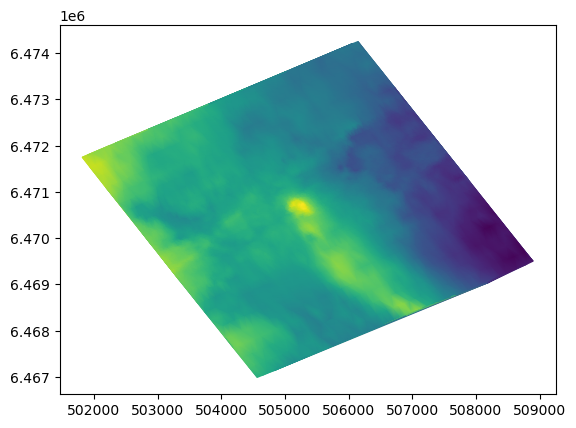

In [52]:
# Change the interpolation method
plt.tripcolor(dat_x, dat_y, grav_v, shading='gouraud')

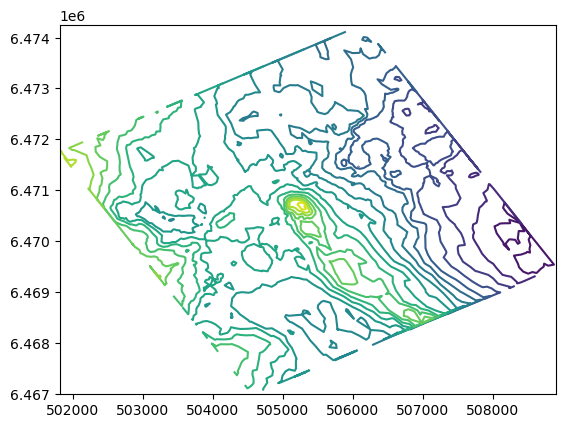

In [44]:
# or contour plots
plt.tricontour(dat_x, dat_y, grav_v, levels=20)

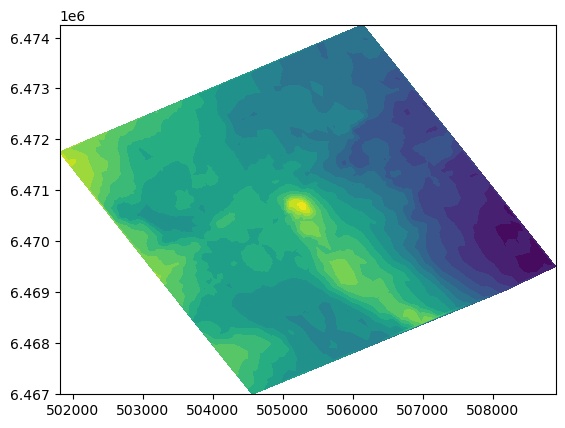

In [45]:
plt.tricontourf(dat_x, dat_y, grav_v, levels=20)

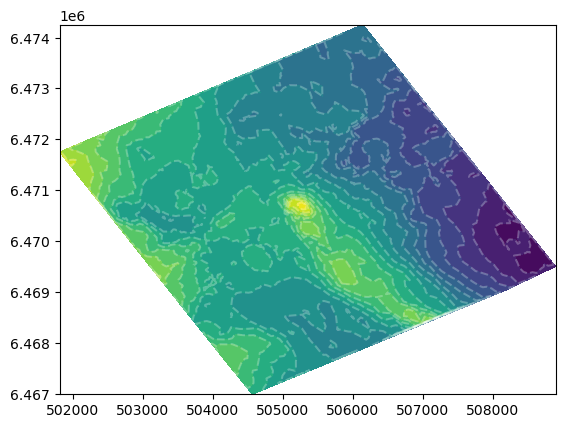

In [64]:
# or both filled and contoured!
plt.tricontourf(dat_x, dat_y, grav_v, levels=20)
plt.tricontour(dat_x, dat_y, grav_v, levels=20, colors='w', alpha=0.25, linestyles='--')

## A note on colorbars

In [91]:
def make_comparison(map1='viridis', map2='jet'):
    plt.figure(figsize=(8,4), dpi=250)
    plt.subplot(1,2,1)
    plt.tripcolor(dat_x, dat_y, grav_v, cmap=map1)
    plt.subplot(1,2,2)
    plt.tripcolor(dat_x, dat_y, grav_v, cmap=map2)

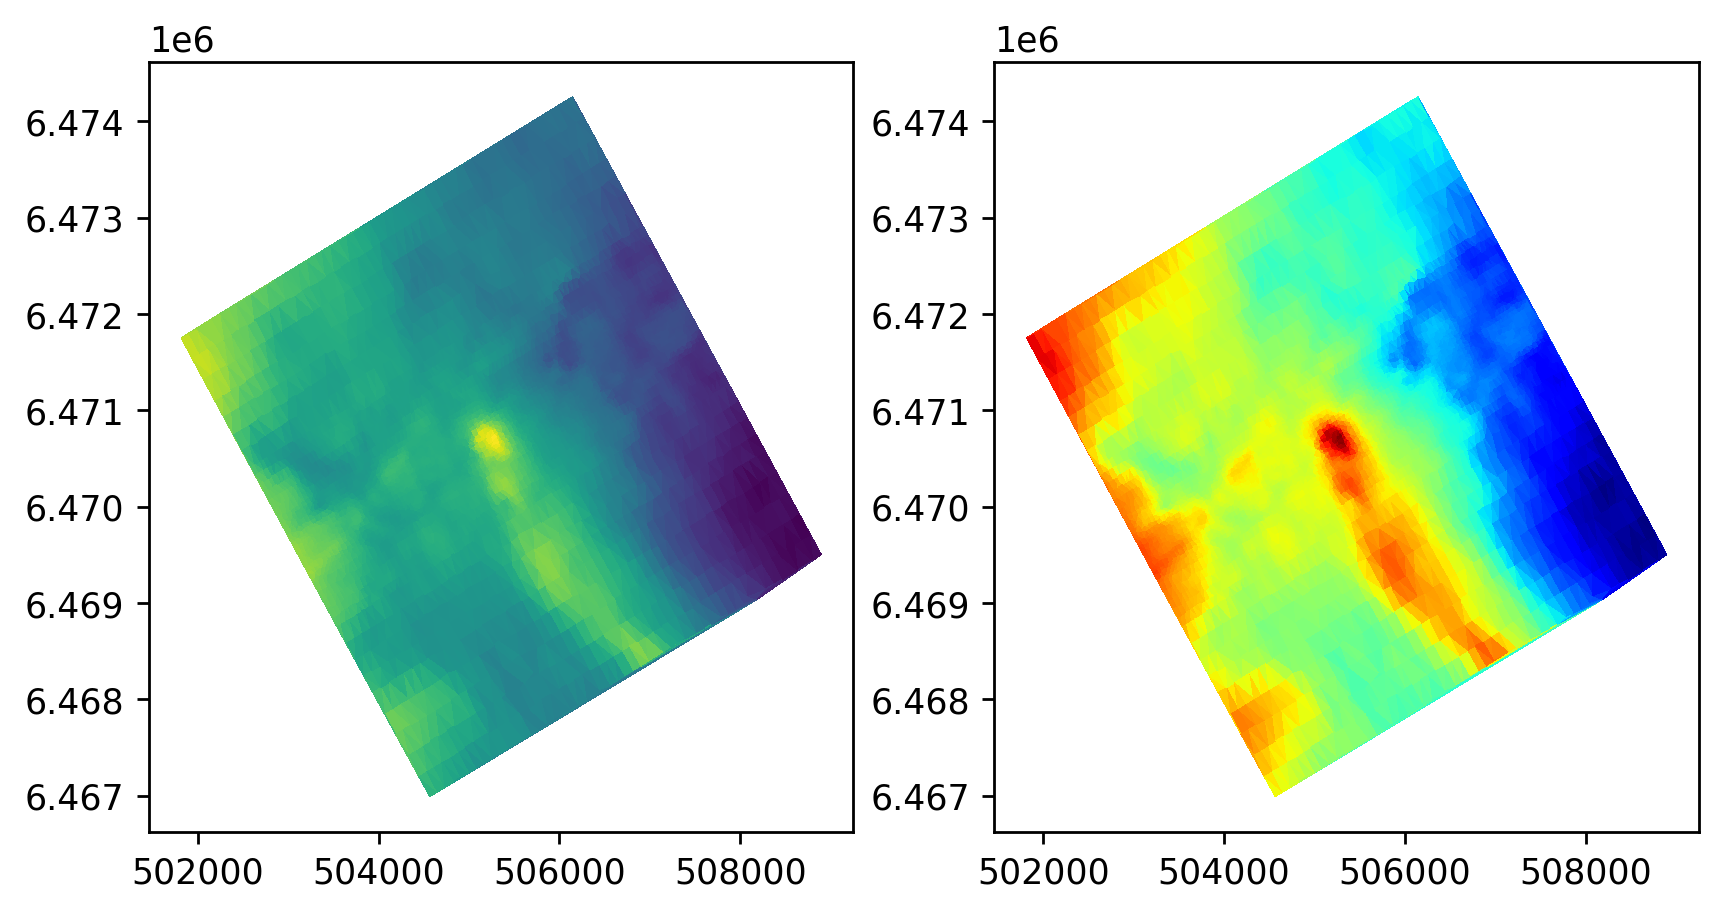

In [92]:
make_comparison()

### What's wrong with Jet?

... alot

In [84]:
import numpy as np
def make_simple(map1='viridis', map2='jet'):
    x = np.linspace(10, 20, 256)
    y = np.ones(100)
    v = x[None, :] * y[:, None]
    
    plt.figure(figsize=(8,4), dpi=250)
    plt.subplot(1,2,1)
    plt.imshow(v, cmap=map1)
    plt.axis('off')
    plt.title(map1)
    
    plt.subplot(1,2,2)
    plt.imshow(v, cmap=map2)
    plt.axis('off')
    plt.title(map2)

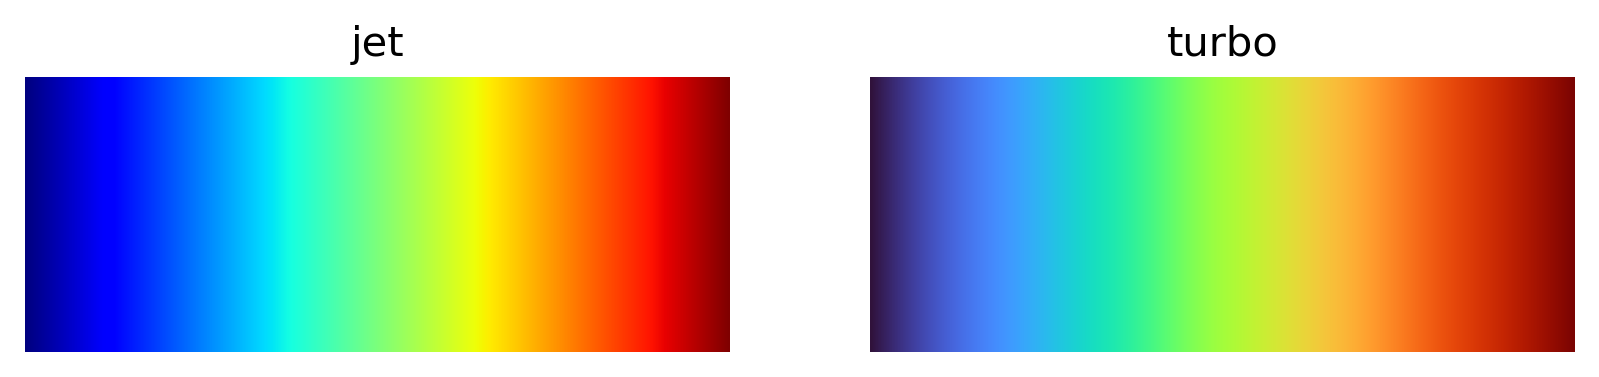

In [93]:
make_simple('jet', 'turbo')

### Colorblindness...
check this out: [changing matplotlib's defaults](https://bids.github.io/colormap/)

### More information
checkout matplotlib's descriptions of colormaps
[here](https://matplotlib.org/stable/users/explain/colors/colormaps.html).